# Name :- Ishant Kundra 

# UIN :- 934008421

# Assignment-1

##  Import Necessary Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.calibration import calibration_curve
from sklearn.preprocessing import LabelEncoder

## Load the Dataset

In [2]:
file_path = 'Employee.csv'
data = pd.read_csv(file_path)

## Encode Categorical Variables

In [3]:
# Identify categorical variables to encode
categorical_columns = ['Education', 'City', 'EverBenched']
label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le

## Define Features and Target Variable

In [4]:
# Exclude protected attributes and target variable from features
X = data.drop(columns=['Age', 'Gender', 'LeaveOrNot'])
y = data['LeaveOrNot']

## Split the Data into Training and Testing Sets

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Initialize and Train the Random Forest Classifier

In [6]:
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

## Predict on Test Data

In [7]:
y_pred = rf_classifier.predict(X_test)
y_probs = rf_classifier.predict_proba(X_test)[:, 1]  # Probabilities for calibration curve

## Prepare Data for Bias Detection Analysis

In [8]:
# Join Age and Gender back for analysis
X_test_with_predictions = X_test.copy()
X_test_with_predictions['Actual'] = y_test
X_test_with_predictions['Predicted'] = y_pred
X_test_with_predictions = X_test_with_predictions.join(data[['Age', 'Gender']], how='left', rsuffix='_true')

## Define Function to Calculate Metrics for Bias Detection

In [9]:
def calculate_metrics(df, group_col, group_values):
    metrics = {}
    for value in group_values:
        group_df = df[df[group_col] == value]
        leave_rate = group_df['Actual'].mean()
        # Calculate Type 1 and Type 2 errors
        fp = ((group_df['Actual'] == 0) & (group_df['Predicted'] == 1)).sum()
        tn = ((group_df['Actual'] == 0) & (group_df['Predicted'] == 0)).sum()
        fn = ((group_df['Actual'] == 1) & (group_df['Predicted'] == 0)).sum()
        tp = ((group_df['Actual'] == 1) & (group_df['Predicted'] == 1)).sum()
        type1_error_rate = fp / (fp + tn) if (fp + tn) > 0 else 0
        type2_error_rate = fn / (fn + tp) if (fn + tp) > 0 else 0
        metrics[value] = {'Leave Rate': leave_rate, 'Type 1 Error Rate': type1_error_rate, 'Type 2 Error Rate': type2_error_rate}
    return metrics

## Calculate and Print Metrics for Age and Gender Groups

In [10]:
# Age groups
X_test_with_predictions['AgeGroup'] = X_test_with_predictions['Age'].apply(lambda x: '<30' if x < 30 else '>=30')
age_metrics = calculate_metrics(X_test_with_predictions, 'AgeGroup', ['<30', '>=30'])

# Gender groups
gender_metrics = calculate_metrics(X_test_with_predictions, 'Gender', ['Male', 'Female'])  

# Convert metrics dictionaries to DataFrames
age_metrics_df = pd.DataFrame(age_metrics).T
gender_metrics_df = pd.DataFrame(gender_metrics).T

print("Age Metrics:\n", age_metrics_df)
print("\nGender Metrics:\n", gender_metrics_df)


Age Metrics:
       Leave Rate  Type 1 Error Rate  Type 2 Error Rate
<30     0.375679           0.057391           0.387283
>=30    0.273684           0.052174           0.376923

Gender Metrics:
         Leave Rate  Type 1 Error Rate  Type 2 Error Rate
Male      0.243276           0.056543           0.452261
Female    0.479239           0.053156           0.335740


## Plot Calibration Curves

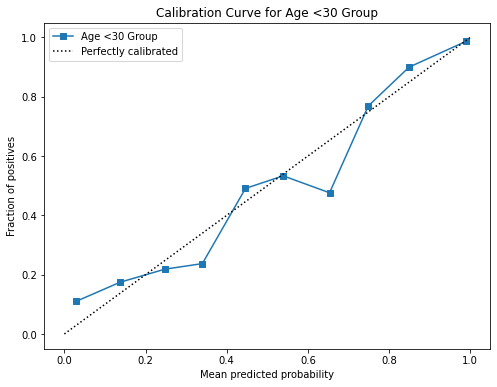

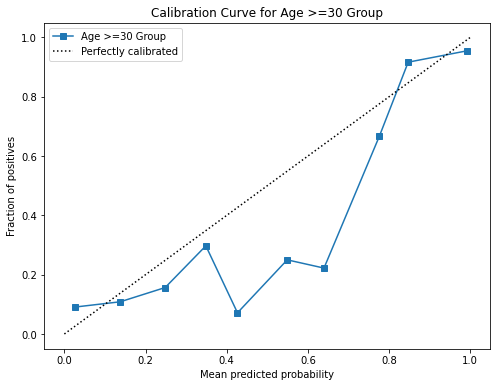

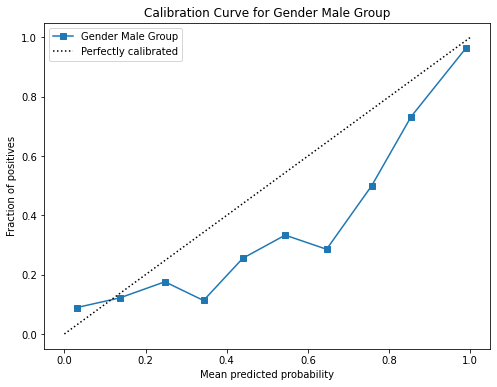

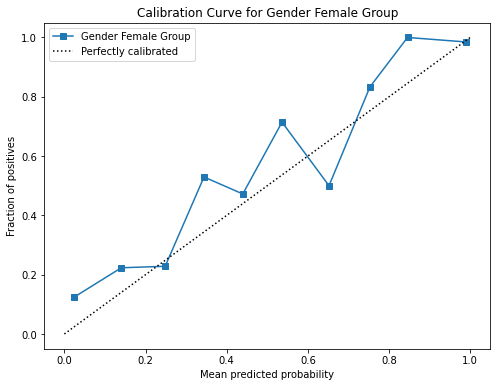

In [11]:
def plot_calibration_curve(y_true, y_prob, group_name):
    fraction_of_positives, mean_predicted_value = calibration_curve(y_true, y_prob, n_bins=10)
    plt.figure(figsize=(8, 6))
    plt.plot(mean_predicted_value, fraction_of_positives, "s-", label=f"{group_name} Group")
    plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
    plt.xlabel('Mean predicted probability')
    plt.ylabel('Fraction of positives')
    plt.title(f'Calibration Curve for {group_name} Group')
    plt.legend()
    plt.show()

# Plot calibration curves for each group
for group in ['<30', '>=30']:
    group_condition = X_test_with_predictions['AgeGroup'] == group
    plot_calibration_curve(X_test_with_predictions.loc[group_condition, 'Actual'], y_probs[group_condition], f'Age {group}')

for gender in ['Male', 'Female']:
    group_condition = X_test_with_predictions['Gender'] == gender
    plot_calibration_curve(X_test_with_predictions.loc[group_condition, 'Actual'], y_probs[group_condition], f'Gender {gender}')

# Further More Detailed Analysis 

## Create combined Age and Gender groups for more detailed analysis

In [12]:
X_test_with_predictions['AgeGenderGroup'] = X_test_with_predictions.apply(
    lambda x: f"{x['Gender']}_{'<30' if x['Age'] < 30 else '>=30'}", axis=1)

In [13]:
# Calculate and Print Metrics for Combined Age and Gender Groups
combined_groups = ['Male_<30', 'Male_>=30', 'Female_<30', 'Female_>=30']
combined_metrics = calculate_metrics(X_test_with_predictions, 'AgeGenderGroup', combined_groups)
combined_metrics_df = pd.DataFrame(combined_metrics).T
print("Combined Age and Gender Metrics:\n", combined_metrics_df)

Combined Age and Gender Metrics:
              Leave Rate  Type 1 Error Rate  Type 2 Error Rate
Male_<30       0.288719           0.064516           0.456954
Male_>=30      0.162712           0.044534           0.437500
Female_<30     0.489950           0.044335           0.333333
Female_>=30    0.455556           0.071429           0.341463


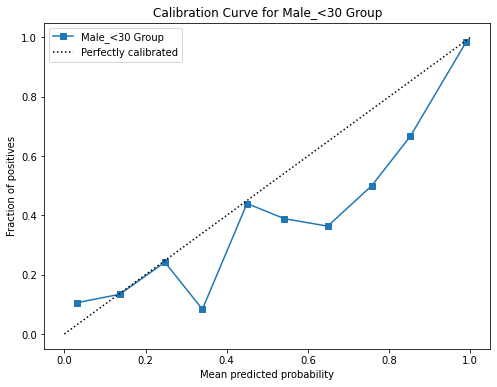

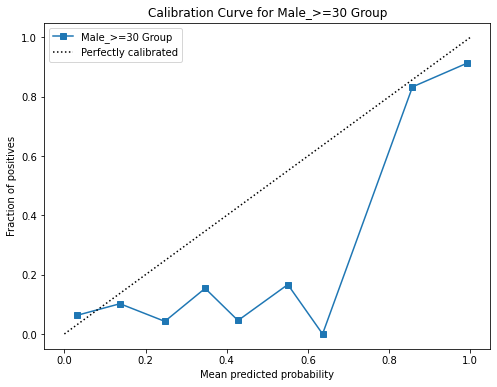

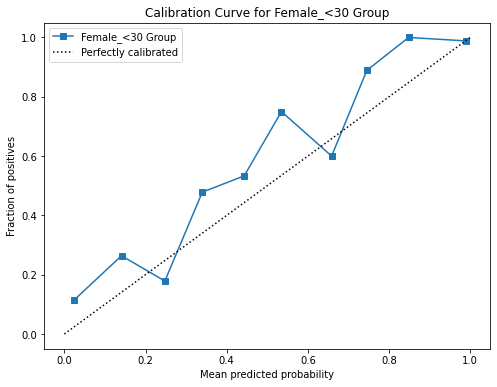

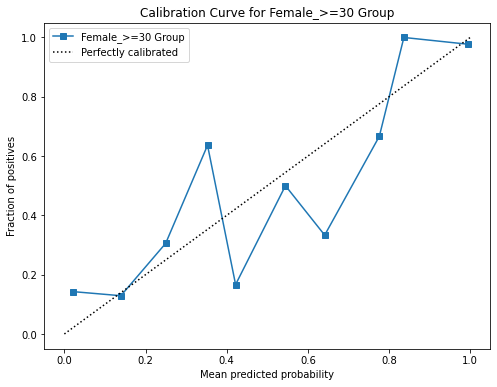

In [14]:
# Plot Calibration Curves for Combined Age and Gender Groups
def plot_combined_calibration_curves(df, groups, y_probs):
    for group in groups:
        group_condition = df['AgeGenderGroup'] == group
        plot_calibration_curve(df.loc[group_condition, 'Actual'], y_probs[group_condition], group)

plot_combined_calibration_curves(X_test_with_predictions, combined_groups, y_probs)